### Bidirectional LSTM Model

A bidirectional LSTM (BiLSTM) enhances the traditional LSTM by processing input sequences in both forward (past to future) and backward (future to past) directions, enabling the model to access context from both preceding and succeeding time steps. This dual approach provides richer sequence understanding and captures dependencies that unidirectional LSTMs might miss, making BiLSTMs especially valuable in tasks like Remaining Useful Life (RUL) prediction and natural language processing. The outputs from both directions are combined—usually by concatenation or summation—to form a comprehensive representation at each time step. While bidirectional LSTMs improve context awareness and accuracy, they require the entire sequence upfront, leading to increased training time and computational complexity, thus being better suited for offline or batch processing rather than real-time streaming.

In [1]:
# --- Import additional layers and tools for experimentation ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau    

c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
import numpy as np
import pandas as pd

# Load rolling window sequences
X = np.load(r"D:\ProgonsAI\milestone_2\week_4\Day_16\rolling_window_sequences.npy")

# Load metadata
metadata = pd.read_csv(r"D:\ProgonsAI\milestone_2\week_4\Day_16\sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (152559, 30, 66)
y shape: (152559,)


In [4]:
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [5]:
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [6]:
# Bidirectional LSTM layer to capture forward and backward temporal dependencies
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model = build_bidirectional_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

c:\Users\roji2\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [8]:
# Model Training
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/30
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 20224.7960
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 52s 25ms/step - loss: 13977.8096 - val_loss: 8441.8984 - learning_rate: 0.0010
Epoch 2/30
1906/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7088.1749
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 50s 26ms/step - loss: 5908.8760 - val_loss: 4289.1680 - learning_rate: 0.0010
Epoch 3/30
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4357.1008
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - loss: 4181.6318 - val_loss: 3832.5154 - learning_rate: 0.0010
Epoch 4/30
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3858.1130
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - loss: 3801.0554 - val_loss: 3466.0078 - learning_rate: 0.0010
Epoch 5/30
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3649.0593
Epoch 5: saving model to best

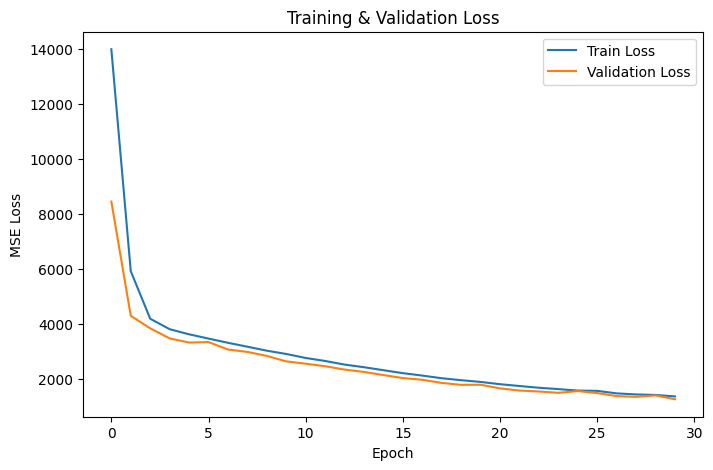

In [9]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


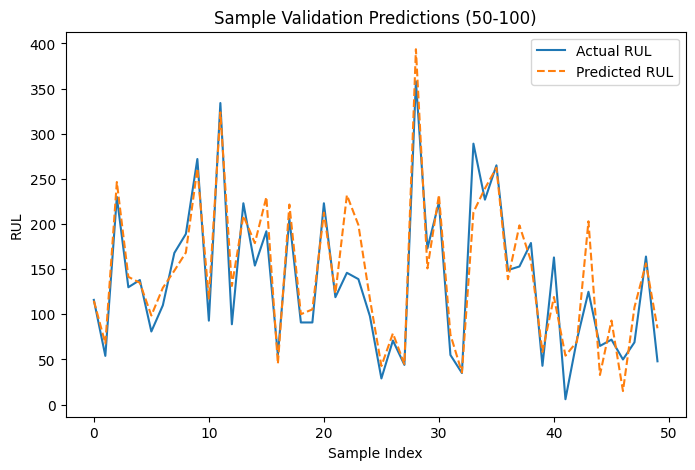

In [10]:
# Verify Model Predictions
val_pred = model.predict(X_val[50:100]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[50:100], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (50-100)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()